In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as scc
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [4]:
print(np.zeros(3))
print(type(np.zeros(3)))

[0. 0. 0.]
<class 'numpy.ndarray'>


In [10]:

def bloch_simulator(t, M, gamma, T1, T2, M0, phi, omega_1, delta_omega, Beff) : 

    #Input
    B1 = omega_1 / gamma
    M = np.array(M)

    #print(f"t: {t}, M: {M}, Beff: {Beff}")  # Check if x is correctly passed
    # Precession
    dMdt = - gamma * np.cross(M, Beff)

    # Relaxation terms
    dMdt[0] += - 1/T2 * M[0]
    dMdt[1] += - 1/T2 * M[1]
    dMdt[2] += - 1/T1 * (M[2] - M0)

    return dMdt

def get_omega_1(t, tw, nz=1) : 
    normal_val = 0.25*1e4

    bound = 0.5*nz*tw
    if(t >= -bound and t <= bound) : 
        normal_val *= np.sin(2*np.pi*t/tw)/(2*np.pi*t/tw)
        return normal_val
    else : 
        return 0 

def get_Beff(x, phi, delta_omega, gamma, G, omega_1) : 
    B1 = omega_1 / gamma

    Beff = np.array([   B1*np.cos(phi),
                        B1*np.sin(phi),
                        delta_omega/gamma                    
    ])

    Beff[2] += G * x

    return Beff

def bloch_simulator_wrapper(t, M, x) : 
    gamma = 2.675 * 1e8 # rad/(T*s)
    T1 = 1000*1e-3
    T2 = 1000*1e-3 
    M0 = 1.0
    phi = np.pi/4
    delta_omega = 0.0 

    delta_x = 2*1e-3 # mm
    tw = 1e-3 # s
    nz = 1
    G = 2*np.pi/(gamma*tw*delta_x)

    omega_1 = get_omega_1(t, tw, nz)
    Beff = get_Beff(x, phi, delta_omega, gamma, G, omega_1)

    return bloch_simulator(t, M, gamma, T1, T2, M0, phi, omega_1, delta_omega, Beff)

In [11]:
#gamma = 2.675 * 1e8 # rad/(T*s)
#R1 = 1/(1000*1e-3) # s
#R2 = 1/(1000*1e-3) # s
#M0 = 1.0
#phi = 0.0
#omega_1 = 4 * 1e6 # Hz
#delta_omega = 0.0 

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)
M0_init = [0.0, 0.0, 1.0]
solution = solve_ivp(fun=bloch_simulator_wrapper, y0=M0_init, t_span=(min(tlin), max(tlin)), t_eval=tlin, max_step=dt, args=(0,))

print(solution)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [-2.000e-03 -2.000e-03 ...  2.000e-03  2.000e-03]
        y: [[ 0.000e+00  0.000e+00 ...  7.024e-01  7.024e-01]
            [ 0.000e+00  0.000e+00 ... -7.024e-01 -7.024e-01]
            [ 1.000e+00  1.000e+00 ...  9.881e-02  9.881e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 239996
     njev: 0
      nlu: 0


In [17]:
print(type(solution))

<class 'scipy.integrate._ivp.ivp.OdeResult'>


In [13]:
print(np.shape(solution.y))
print(solution.y[1] == np.ones_like(solution.y[2]))

(3, 40000)
[False False False ... False False False]


0.09881358075976447


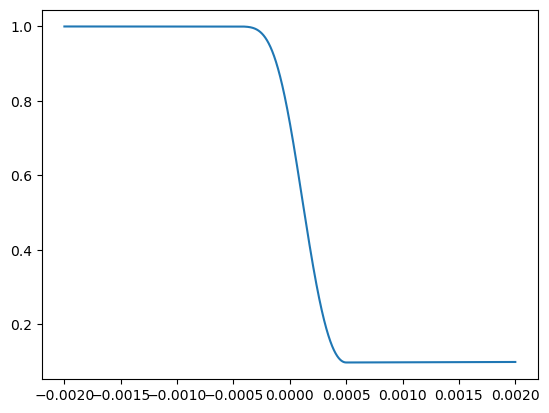

In [14]:
plt.plot(tlin, solution.y[2], '-')
#plt.xlim(1e-3 - 50*dt, 1e-3 + 50*dt)

print(solution.y[2][-1])

# PI PULSE: 0.5 E4
# PI/2 PULSE: 0.25 E4

In [278]:
index = np.where(np.isclose(solution.t, 0.5e-3))[0][0]
print(solution.y[:,index])


[ 0.81931544 -0.56366807  0.10139434]


In [286]:
length = 10*1e-2 # m
Ls = np.arange(-length, length, 0.5e-2)

Ms = []

for x in Ls : 
    solution = solve_ivp(fun=bloch_simulator_wrapper, y0=M0_init, t_span=(min(tlin), max(tlin)), t_eval=tlin, max_step=dt, args=(x,))

    index = np.where(np.isclose(solution.t, 0.5e-3))[0][0]

    Ms.append( solution.y[:,index] )


(0.0, 0.1)

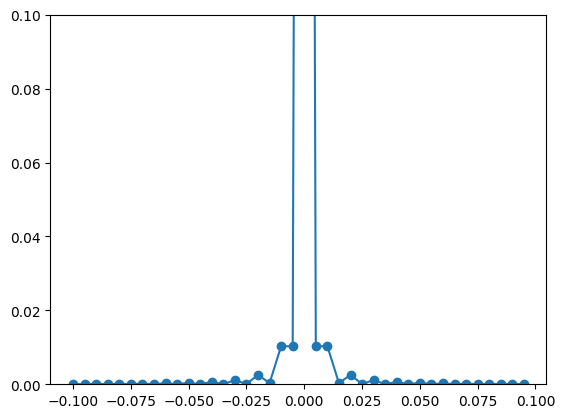

In [289]:
Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)

plt.plot(Ls, Mps, 'o-')
plt.ylim(0.0, 0.1)

In [1]:
import warnings
import numpy as np
from numpy._typing._array_like import NDArray


class Bloch_Simulator() : 
                                        
    def __init__(self, gamma = 2.675 * 1e8,         # rad/(T*s) 
                    T1 = 1000*1e-3, T2=1000*1e-3,   # s 
                    M0 = 1.0, 
                    phi = 0.0, 
                    omega_1 = 0.25 * 1e4,           # 1/s 
                    delta_omega = 0.0,              # 1/s 
                    nz = 1.0,                       # nmb. 
                    tw = 1 * 1e-3,                  # s 
                    G = None, 
                    lower_bound=-np.inf, upper_bound=np.inf
                )  -> None:
        # Constants
        self.delta_x = 2 * 1e-3                     # m
        # Parameters
        self.gamma = gamma
        self.T1 = T1
        self.T2 = T2
        self.M0 = M0
        self.phi = phi
        self.omega_1 = omega_1
        self.delta_omega = delta_omega
        self.nz = nz
        self.tw = tw
        if(G) : self.G = 2*np.pi/(self.gamma*self.tw*self.delta_x)
        else :  self.G = G
        # Pulse bounds
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        # Logged information
        self.last_solution = None

    def _get_Beff(self, t: float, x: float, apply_sinc: bool)  -> np.ndarray:
        B1 = self._get_omega1(t) / self.gamma
        Beff = np.zeros(3)
        
        Beff[0] += B1*np.cos(self.phi)
        Beff[1] += B1*np.sin(self.phi)
        Beff[2] += self.delta_omega/self.gamma

        if(apply_sinc) : Beff *= np.sin(2*np.pi*t/self.tw)/(2*np.pi*t/self.tw)

        if(x) : Beff[2] += self.G * x

        return Beff


    def _get_omega1(self, t: float) -> float: 
        
        if(t >= self.lower_bound and t <= self.upper_bound) : 
            return self.omega_1
        else : 
            return 0
    
    def _diff_eqn(self, t: float, M: list, x: float, apply_sinc: bool) -> np.ndarray: 
        
        
        M = np.array(M)
        Beff = self._get_Beff(t, x, apply_sinc)
        
        # Precession
        dMdt = - self.gamma * np.cross(M, Beff)

        # Relaxation terms
        dMdt[0] += - 1/self.T2 * M[0]
        dMdt[1] += - 1/self.T2 * M[1]
        dMdt[2] += - 1/self.T1 * (M[2] - self.M0)

        return dMdt

    def solve_ivp(self, dt: float, tlin: list, x: float, apply_sinc=True, force_max_step_size=False) : # -> OdeResult
        M0_init = np.array([0.0, 0.0, self.M0])
        step_size = dt if force_max_step_size else None

        print(step_size)

        solution = solve_ivp(fun=self._diff_eqn, 
                             y0=M0_init, 
                             t_span=(min(tlin), max(tlin)), 
                             t_eval=tlin, 
                             max_step=step_size,
                             args=(x, apply_sinc,)
                             )
                    
        self.last_solution = solution

        if not solution.success : warnings.warn(solution.message, UserWarning)

        return solution
        

In [5]:

gamma = 2.675 * 1e8 # rad/(T*s)
T1 = 1000*1e-3
T2 = 1000*1e-3 
M0 = 1.0
phi = np.pi/4
delta_omega = 0.0 

delta_x = 2*1e-3 # mm
tw = 1e-3 # s
nz = 1
bound = 0.5*nz*tw 

G = 2*np.pi/(gamma*tw*delta_x)

solver = Bloch_Simulator(lower_bound=-bound, upper_bound=bound)

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)
M0_init = [0.0, 0.0, 1.0]

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=True)

1.0000000000000001e-07


In [6]:
print(np.shape(solution.y))
print(solution.y[1] == np.ones_like(solution.y[2]))

(3, 40000)
[False False False ... False False False]


0.09881358075976675


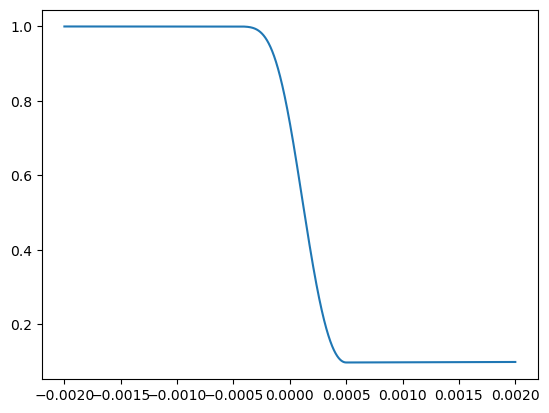

In [7]:
plt.plot(tlin, solution.y[2], '-')
#plt.xlim(1e-3 - 50*dt, 1e-3 + 50*dt)

print(solution.y[2][-1])